In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

sys.path.insert(0, '/home/sharifullina/thesis/Soft-DTW-Loss/')
from sdtw_cuda_loss import SoftDTW

In [2]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/datasets/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

# dataset

In [5]:
wells = os.listdir(target_folder)
len(wells)

23

In [6]:
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

In [7]:
logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [8]:
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

In [9]:
X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])

In [10]:
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

In [11]:
X = []
for i in X_list_minus:
    X.append(i.values)

In [12]:
X = np.dstack(X)
X = np.rollaxis(X, -1)
X.shape

(5901, 256, 5)

In [13]:
map_well_to_label = {w:i for i, w in enumerate(wells)}

In [14]:
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])
y.shape

(5901,)

In [15]:
class DataSet():
    def __init__(self, data, labels, feature_scales={}, N=25000, length_lim=90, sparse_rate=1):

#         if len(data) > N:
#             sub_inds = np.random.choice(len(data), N, replace=False)
#         else:
#             sub_inds = np.arange(len(data))
        
        self.data = data
        self.data = torch.tensor(self.data).to(torch.float32)
        self.labels = torch.tensor(labels)
        self.sparse_rate = sparse_rate
        self.feature_scales = feature_scales
        
        for f in range(data.shape[2]):
            self.data[:, :, f] = (self.data[:, :, f].T - self.data[:, :, f].mean(axis=1)).T 
            
        for f in range(data.shape[2]):
            if f not in feature_scales:
                std = self.data[:, :, f].ravel().std()
                feature_scales[f] = std
            self.data[:, :, f] = self.data[:, :, f]/feature_scales[f]
            
        self.data = self.data.transpose(1, 2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

In [16]:
torch_dataset = DataSet(X, y, sparse_rate=1)


In [17]:
train_n = 4000
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [18]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [19]:
for x_t, y_t in train_loader:
    print(x_t.shape)
    print(y_t.shape)
    break

torch.Size([64, 5, 256])
torch.Size([64])


---

# Model

In [20]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 2, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose1d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=len(required_params), features=32):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv1d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv1d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 , features, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose1d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            # nn.Tanh(),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        return d6
    
        

    def forward(self, x):
#         print('x', x.shape)
        d1 = self.initial_down(x)
#         print('d1', d1.shape)
        d2 = self.down1(d1)
#         print('d2', d2.shape)
        d3 = self.down2(d2)
#         print('d3', d3.shape)
        d4 = self.down3(d3)
#         print('d4', d4.shape)
        d5 = self.down4(d4)
#         print('d5', d5.shape)
        d6 = self.down5(d5)
#         print('d6', d6.shape)
        bottleneck = self.bottleneck(d6)
#         print('bottleneck', bottleneck.shape)
        up1 = self.up1(bottleneck)
#         print('up1', up1.shape)
        if up1.shape != d6.shape:
            up1 = TF.resize(up1, size=d6.shape[1:]) 
        up2 = self.up2(torch.cat([up1, d6], 1))
#         print('up2', up2.shape)
        if up2.shape != d5.shape:
            up2 = TF.resize(up2, size=d5.shape[1:])
        up3 = self.up3(torch.cat([up2, d5], 1))
#         print('up3', up3.shape)
        if up3.shape != d4.shape:
            up3 = TF.resize(up3, size=d4.shape[1:])
        up4 = self.up4(torch.cat([up3, d4], 1))
#         print('up4', up4.shape)
        if up4.shape != d3.shape:
            up4 = TF.resize(up4, size=d3.shape[1:])
        up5 = self.up5(torch.cat([up4, d3], 1))
#         print('up5', up5.shape)
        if up5.shape != d2.shape:
            up5 = TF.resize(up5, size=d2.shape[1:])
        up6 = self.up6(torch.cat([up5, d2], 1))
#         print('up6', up6.shape)
        if up6.shape != d1.shape:
            up6 = TF.resize(up6, size=d1.shape[1:])
        return self.final_up(torch.cat([up6, d1], 1))
        

In [21]:
# check
model_gen = Generator()
for i, data in enumerate(train_loader):
    x, y = data
    print(x.shape)
    print(y.shape)
    out = model_gen(x)
    break

out.shape

torch.Size([64, 5, 256])
torch.Size([64])


torch.Size([64, 5, 256])

In [22]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=len(required_params), features=[32, 64, 128, 256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(
                in_channels ,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv1d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        return x


In [23]:
# check
model_disk = Discriminator()
for i, data in enumerate(train_loader):
    x, y = data
    out = model_disk(x)
    break

out.shape

torch.Size([64, 1, 30])

## inception time

In [24]:
from inceptiontime.src.models.inception import InceptionModel

In [25]:
model_inception = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).cuda()

In [26]:
optimizer = torch.optim.Adam(model_inception.parameters(), lr=1e-3)
best_val_loss = np.inf
patience_counter = 0
best_state_dict = None
criterion = nn.CrossEntropyLoss()

In [27]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100

In [28]:
for epoch in range(num_epochs):
    model_inception.train();
    epoch_train_loss = []
    all_preds = []
    all_y = []
    for x_t, y_t in train_loader:
        x_t = x_t.cuda()
        y_t = y_t.cuda()
        optimizer.zero_grad()
        output = model_inception(x_t)
        loss = criterion(output, y_t)
        epoch_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        _, preds = torch.max(output, 1)
        all_preds.append(preds)
        all_y.append(y_t)
    train_loss.append(np.mean(epoch_train_loss))
    train_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))
    epoch_val_loss = []
    model_inception.eval()
    all_preds = []
    all_y = []
    for x_v, y_v in val_loader:
        x_v = x_v.cuda()
        y_v = y_v.cuda()
        with torch.no_grad():
            output = model_inception(x_v)
            loss = criterion(output, y_v)
            epoch_val_loss.append(loss.item())
            _, preds = torch.max(output, 1)
            all_preds.append(preds)
            all_y.append(y_v)
    val_loss.append(np.mean(epoch_val_loss))
    val_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))

    print(f'Epoch: {epoch + 1}, '
          f'Train loss: {round(train_loss[-1], 3)}, '
          f'Val loss: {round(val_loss[-1], 3)}, '
          f'Train acc: {round(train_acc[-1], 3)}, '
          f'Val acc: {round(val_acc[-1], 3)}, ')

Epoch: 1, Train loss: 3.006, Val loss: 2.916, Train acc: 0.083, Val acc: 0.093, 
Epoch: 2, Train loss: 2.798, Val loss: 2.772, Train acc: 0.139, Val acc: 0.151, 
Epoch: 3, Train loss: 2.706, Val loss: 2.709, Train acc: 0.159, Val acc: 0.155, 
Epoch: 4, Train loss: 2.618, Val loss: 2.625, Train acc: 0.185, Val acc: 0.155, 
Epoch: 5, Train loss: 2.546, Val loss: 2.55, Train acc: 0.199, Val acc: 0.183, 
Epoch: 6, Train loss: 2.508, Val loss: 2.515, Train acc: 0.215, Val acc: 0.198, 
Epoch: 7, Train loss: 2.484, Val loss: 2.498, Train acc: 0.214, Val acc: 0.211, 
Epoch: 8, Train loss: 2.443, Val loss: 2.528, Train acc: 0.225, Val acc: 0.183, 
Epoch: 9, Train loss: 2.431, Val loss: 2.491, Train acc: 0.222, Val acc: 0.195, 
Epoch: 10, Train loss: 2.422, Val loss: 2.423, Train acc: 0.225, Val acc: 0.234, 
Epoch: 11, Train loss: 2.398, Val loss: 2.416, Train acc: 0.236, Val acc: 0.232, 
Epoch: 12, Train loss: 2.355, Val loss: 2.394, Train acc: 0.241, Val acc: 0.238, 
Epoch: 13, Train loss: 2.3

## training model

In [39]:
lr = 3e-4
batch_size = 128
num_epochs = 100
n_noise = 256
n_critic = 1

In [40]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion_gan = nn.BCELoss()
criterion_soft_dtw = SoftDTW(use_cuda=True, gamma=0.1)
D_opt = torch.optim.Adam(discriminator.parameters(), lr = lr)
G_opt = torch.optim.Adam(generator.parameters(), lr = lr)
# Soft_dtw_opt = torch.optim.Adam(generator.parameters(), lr = lr)
fixed_noise = torch.randn((batch_size, len(required_params), 64)).to(device)

In [41]:
print('Discriminator paramteres:', sum(p.numel() for p in discriminator.parameters() if p.requires_grad))
print('Generator paramteres:', sum(p.numel() for p in generator.parameters() if p.requires_grad))

Discriminator paramteres: 174625
Generator paramteres: 2419237


In [42]:
writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/fake")
writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/real")

In [43]:
G_losses = []
D_losses = []
img_list = []

In [44]:
generator.train()
discriminator.train()

G_loss_list = []
D_loss_list = []

for epoch in range(num_epochs):
    for idx, data_all in enumerate(train_loader):
    
        step = 0
        data, y = data_all
        data = data.to(device)
        y = y.to(device)
        real_data = data.to(device)
        batch_size = real_data.size(0)
        noise = torch.randn(real_data.size(0), len(required_params), 64, device=device)

        D_opt.zero_grad()
        G_opt.zero_grad()

        fake = generator(noise)
#         Ssim_loss = criterion_ssim(real_data, noise)
        # classificator
        output_class = model_inception(data)
        loss_class = criterion(output_class, y)

        disc_real = discriminator(real_data)        
        D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))        
        disc_fake = discriminator(fake)
        D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
        D_loss = (D_loss_1 + D_loss_2) / 2 + loss_class * 0.001
#         + abs(Ssim_loss)
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        D_opt.step()

        output = discriminator(fake)
        G_loss = criterion_gan(output, torch.ones_like(output))
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        G_loss_list.append(G_loss.item())
        D_loss_list.append(D_loss.item())

        if idx % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(train_loader)} \
            Loss D: {D_loss:.4f}, loss G: {G_loss:.4f}")

            step += 1
            


Epoch [0/100] Batch 0/63             Loss D: 0.7333, loss G: 0.6709
Epoch [0/100] Batch 10/63             Loss D: 0.6777, loss G: 1.0509
Epoch [0/100] Batch 20/63             Loss D: 0.5467, loss G: 1.4147
Epoch [0/100] Batch 30/63             Loss D: 0.5723, loss G: 1.2503
Epoch [0/100] Batch 40/63             Loss D: 0.4189, loss G: 1.9874
Epoch [0/100] Batch 50/63             Loss D: 0.3884, loss G: 1.9457
Epoch [0/100] Batch 60/63             Loss D: 0.5019, loss G: 1.6118
Epoch [1/100] Batch 0/63             Loss D: 0.4417, loss G: 1.6089
Epoch [1/100] Batch 10/63             Loss D: 0.4234, loss G: 1.9329
Epoch [1/100] Batch 20/63             Loss D: 0.3944, loss G: 2.4319
Epoch [1/100] Batch 30/63             Loss D: 0.2339, loss G: 2.4596
Epoch [1/100] Batch 40/63             Loss D: 0.2292, loss G: 2.2252
Epoch [1/100] Batch 50/63             Loss D: 0.3829, loss G: 1.8064
Epoch [1/100] Batch 60/63             Loss D: 0.3347, loss G: 1.8499
Epoch [2/100] Batch 0/63            

Epoch [17/100] Batch 10/63             Loss D: 0.0133, loss G: 4.9356
Epoch [17/100] Batch 20/63             Loss D: 0.0390, loss G: 4.7775
Epoch [17/100] Batch 30/63             Loss D: 0.0195, loss G: 4.4395
Epoch [17/100] Batch 40/63             Loss D: 0.0127, loss G: 5.1104
Epoch [17/100] Batch 50/63             Loss D: 0.0090, loss G: 5.0519
Epoch [17/100] Batch 60/63             Loss D: 0.0197, loss G: 4.6310
Epoch [18/100] Batch 0/63             Loss D: 0.0188, loss G: 4.1276
Epoch [18/100] Batch 10/63             Loss D: 0.0201, loss G: 4.7736
Epoch [18/100] Batch 20/63             Loss D: 0.0182, loss G: 5.3359
Epoch [18/100] Batch 30/63             Loss D: 0.0090, loss G: 5.3589
Epoch [18/100] Batch 40/63             Loss D: 0.0132, loss G: 5.2658
Epoch [18/100] Batch 50/63             Loss D: 0.0189, loss G: 5.2209
Epoch [18/100] Batch 60/63             Loss D: 0.0108, loss G: 4.8969
Epoch [19/100] Batch 0/63             Loss D: 0.0465, loss G: 4.4485
Epoch [19/100] Batch 1

Epoch [34/100] Batch 10/63             Loss D: 0.0238, loss G: 6.1473
Epoch [34/100] Batch 20/63             Loss D: 0.0147, loss G: 5.1272
Epoch [34/100] Batch 30/63             Loss D: 0.0093, loss G: 5.2573
Epoch [34/100] Batch 40/63             Loss D: 0.0078, loss G: 5.1894
Epoch [34/100] Batch 50/63             Loss D: 0.0100, loss G: 5.0212
Epoch [34/100] Batch 60/63             Loss D: 0.0069, loss G: 5.1187
Epoch [35/100] Batch 0/63             Loss D: 0.0063, loss G: 5.2520
Epoch [35/100] Batch 10/63             Loss D: 0.0077, loss G: 5.0335
Epoch [35/100] Batch 20/63             Loss D: 0.0078, loss G: 5.1540
Epoch [35/100] Batch 30/63             Loss D: 0.0063, loss G: 5.4681
Epoch [35/100] Batch 40/63             Loss D: 0.0062, loss G: 5.3914
Epoch [35/100] Batch 50/63             Loss D: 0.0108, loss G: 5.2312
Epoch [35/100] Batch 60/63             Loss D: 0.0046, loss G: 6.4903
Epoch [36/100] Batch 0/63             Loss D: 0.0054, loss G: 5.8146
Epoch [36/100] Batch 1

Epoch [51/100] Batch 10/63             Loss D: 0.0034, loss G: 6.6120
Epoch [51/100] Batch 20/63             Loss D: 0.0033, loss G: 6.8755
Epoch [51/100] Batch 30/63             Loss D: 0.0028, loss G: 6.7862
Epoch [51/100] Batch 40/63             Loss D: 0.0034, loss G: 6.8043
Epoch [51/100] Batch 50/63             Loss D: 0.0028, loss G: 7.4060
Epoch [51/100] Batch 60/63             Loss D: 0.0027, loss G: 6.9097
Epoch [52/100] Batch 0/63             Loss D: 0.0027, loss G: 7.3737
Epoch [52/100] Batch 10/63             Loss D: 0.0029, loss G: 7.0992
Epoch [52/100] Batch 20/63             Loss D: 0.0051, loss G: 6.8377
Epoch [52/100] Batch 30/63             Loss D: 0.0027, loss G: 7.5820
Epoch [52/100] Batch 40/63             Loss D: 0.0026, loss G: 7.8722
Epoch [52/100] Batch 50/63             Loss D: 0.0031, loss G: 7.3222
Epoch [52/100] Batch 60/63             Loss D: 0.0050, loss G: 7.3104
Epoch [53/100] Batch 0/63             Loss D: 0.0028, loss G: 7.8626
Epoch [53/100] Batch 1

Epoch [68/100] Batch 10/63             Loss D: 0.0020, loss G: 8.4241
Epoch [68/100] Batch 20/63             Loss D: 0.0025, loss G: 7.6160
Epoch [68/100] Batch 30/63             Loss D: 0.0025, loss G: 7.6716
Epoch [68/100] Batch 40/63             Loss D: 0.0029, loss G: 7.4531
Epoch [68/100] Batch 50/63             Loss D: 0.0025, loss G: 7.3625
Epoch [68/100] Batch 60/63             Loss D: 0.0030, loss G: 8.5629
Epoch [69/100] Batch 0/63             Loss D: 0.0071, loss G: 8.0667
Epoch [69/100] Batch 10/63             Loss D: 0.0029, loss G: 8.6008
Epoch [69/100] Batch 20/63             Loss D: 0.0026, loss G: 7.9513
Epoch [69/100] Batch 30/63             Loss D: 0.0024, loss G: 7.9855
Epoch [69/100] Batch 40/63             Loss D: 0.0024, loss G: 9.0457
Epoch [69/100] Batch 50/63             Loss D: 0.0026, loss G: 8.8357
Epoch [69/100] Batch 60/63             Loss D: 0.0021, loss G: 8.6379
Epoch [70/100] Batch 0/63             Loss D: 0.0025, loss G: 8.6827
Epoch [70/100] Batch 1

Epoch [85/100] Batch 10/63             Loss D: 0.0027, loss G: 7.4536
Epoch [85/100] Batch 20/63             Loss D: 0.0029, loss G: 7.4035
Epoch [85/100] Batch 30/63             Loss D: 0.0032, loss G: 7.5244
Epoch [85/100] Batch 40/63             Loss D: 0.0026, loss G: 8.1022
Epoch [85/100] Batch 50/63             Loss D: 0.0031, loss G: 8.8768
Epoch [85/100] Batch 60/63             Loss D: 0.0030, loss G: 8.4294
Epoch [86/100] Batch 0/63             Loss D: 0.0045, loss G: 8.2675
Epoch [86/100] Batch 10/63             Loss D: 0.0038, loss G: 7.8720
Epoch [86/100] Batch 20/63             Loss D: 0.0033, loss G: 7.6685
Epoch [86/100] Batch 30/63             Loss D: 0.0038, loss G: 7.4925
Epoch [86/100] Batch 40/63             Loss D: 0.0047, loss G: 8.1031
Epoch [86/100] Batch 50/63             Loss D: 0.0055, loss G: 8.4108
Epoch [86/100] Batch 60/63             Loss D: 0.0035, loss G: 8.3406
Epoch [87/100] Batch 0/63             Loss D: 0.0052, loss G: 8.2177
Epoch [87/100] Batch 1

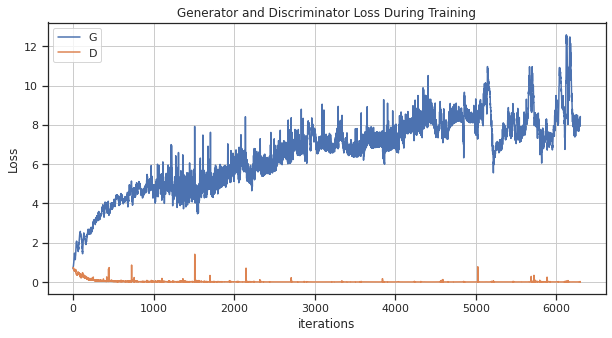

In [46]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_list,label="G")
plt.plot(D_loss_list,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig('/home/sharifullina/thesis/losses/loss_cGAN_time_series_inception_class.png')
plt.show()

## test

In [47]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [48]:
test_well = wells[22]
test_well

'well_17.json'

In [49]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [50]:
y_name = 'DEPTH'

In [51]:
X_test

,DEPTH,ROPA,HKLA,WOB,SPPA
0,223.0,1.50,96.39,0.19,84.75
1,224.0,3.84,97.11,0.60,77.10
2,225.0,3.51,96.76,0.58,85.56
3,226.0,21.85,97.11,0.36,53.67
4,227.0,33.79,94.76,2.55,53.96
...,...,...,...,...,...
3405,3628.0,15.04,156.24,5.77,218.70
3406,3629.0,15.04,155.61,6.36,218.79
3407,3630.0,15.04,155.27,6.58,218.60
3408,3631.0,15.04,155.71,6.26,218.71


In [52]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = generator(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [53]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [54]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:04<00:00, 173.10it/s]


837it [00:00, 195371.61it/s]
/tmp/ipykernel_36379/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 219044.89it/s]
/tmp/ipykernel_36379/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 211292.96it/s]
/tmp/ipykernel_36379/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 195513.06it/s]
/tmp/ipykernel_36379/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 205120.21it/s]
/tmp/ipykernel_36379/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


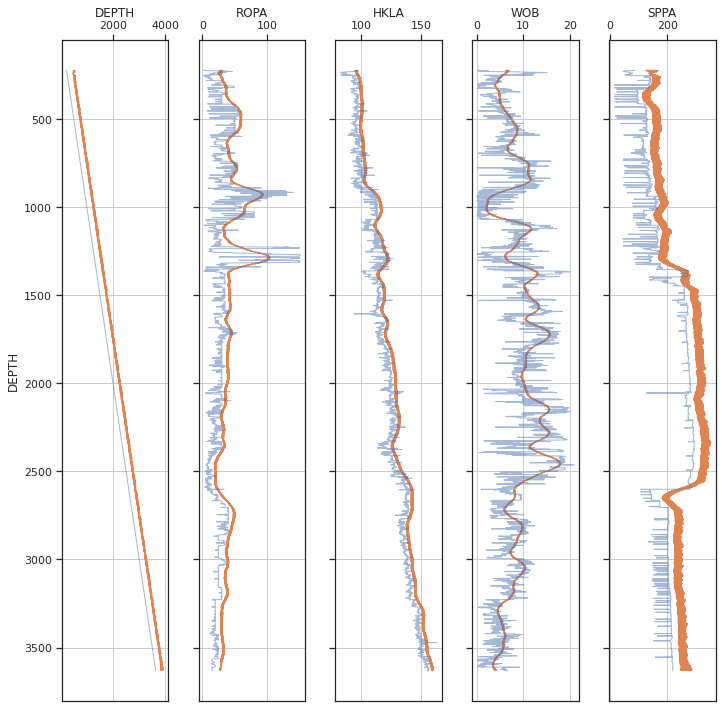

In [55]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
#     for zi, x in tqdm(enumerate(range(0, len(df_well) - window, step))):
#         plt.plot(Z[zi][0][:, i], t[np.arange(x, x+window, sparse_rate)], color='C1', alpha=0.5, lw=0.5)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    original.append(X_test[curve_name].astype(float).values)
    generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()


In [97]:
df1 = pd.DataFrame(original).T
df1.columns = required_params
df1 = df1.assign(WELL=lambda x: 'original')

df2 = pd.DataFrame(generated).T
df2.columns = required_params
df2 = df2.assign(WELL=lambda x: 'generated')

df_some = pd.concat([df1, df2], ignore_index = True)
df_some

,DEPTH,ROPA,HKLA,WOB,SPPA,WELL
0,223.000000,1.500000,96.390000,0.190000,84.750000,original
1,224.000000,3.840000,97.110000,0.600000,77.100000,original
2,225.000000,3.510000,96.760000,0.580000,85.560000,original
3,226.000000,21.850000,97.110000,0.360000,53.670000,original
4,227.000000,33.790000,94.760000,2.550000,53.960000,original
...,...,...,...,...,...,...
6813,3827.166168,26.954540,159.267323,4.454938,266.663976,generated
6814,3830.842117,26.716468,159.365762,4.660939,267.053649,generated
6815,3838.715637,26.394381,159.198082,4.664370,265.966693,generated
6816,3832.157639,26.483802,159.329444,4.690721,268.068808,generated


inception score

In [56]:
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

In [60]:
time1= torch.randn(64, 5, 256)
IS, IS_std = get_inception_score(time1)
IS_std

ValueError: size shape must match input shape. Input is 1D, size is 2

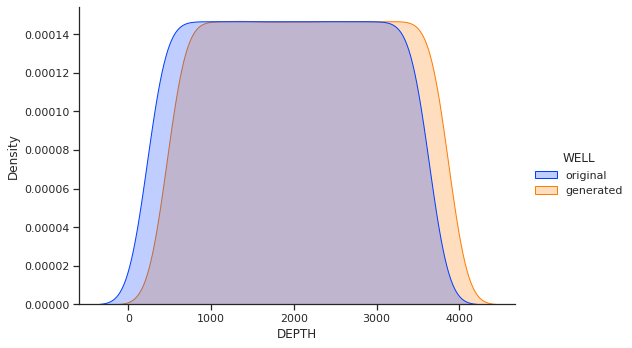

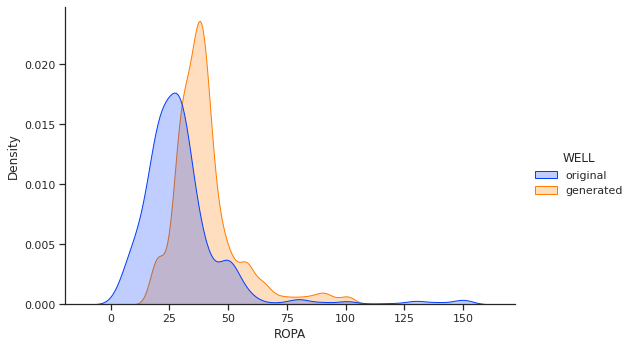

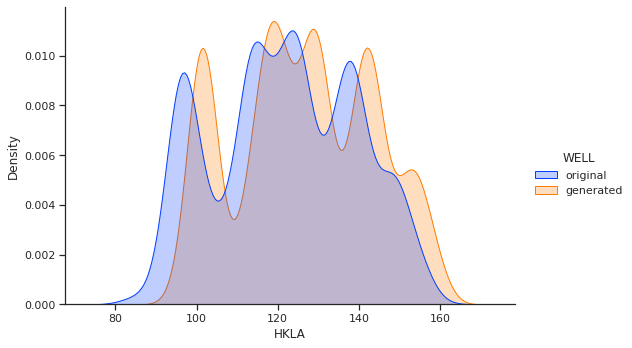

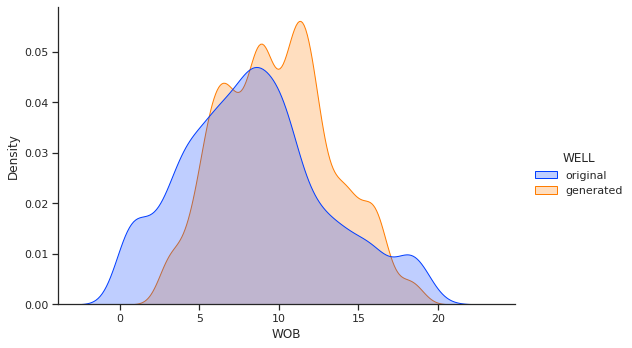

In [98]:
for i in required_params[:-1]:
    sns.displot(data=df_some, 
            x=i, hue='WELL', kind='kde',
            fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
               )